Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.NI8CCJ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.NI8CCJ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Dataset prepared.

Running Experiment 1: MP + Tr + BCE
Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7016 - dice_coef: 0.4996 - loss: 0.5887 - val_accuracy: 0.3426 - val_dice_coef: 0.4707 - val_loss: 120.5633
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 497ms/step - accuracy: 0.8593 - dice_coef: 0.6531 - loss: 0.3511 - val_accuracy: 0.6714 - val_dice_coef: 0.6149 - val_loss: 8.5229
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - accuracy: 0.8879 - dice_coef: 0.7168 - loss: 0.2776 - val_accuracy: 0.8252 - val_dice_coef: 0.7039 - val_loss: 1.0134
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 488ms/step - accuracy: 0.9016 - dice_coef: 0.7469 - loss: 0.2419 - val_accuracy: 0.8352 - val_dice_coef: 0.6997 - val_loss: 0.7601
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 497ms/step - accuracy: 0.9128 - dice_coef: 0.7790 - loss: 0.2144 - val_a

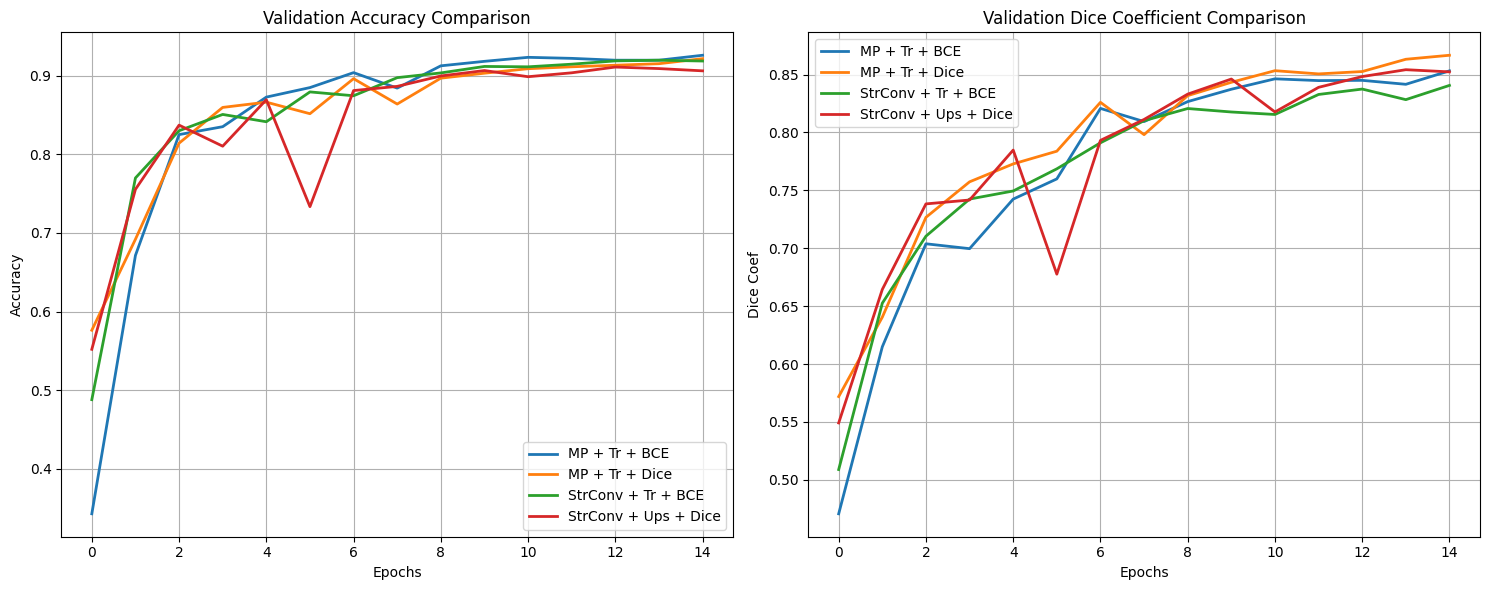

Visualizing predictions from the last trained model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step


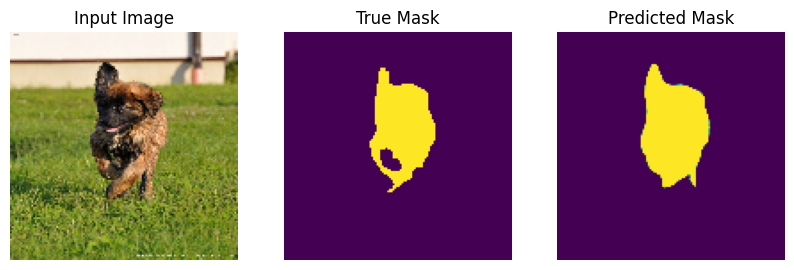

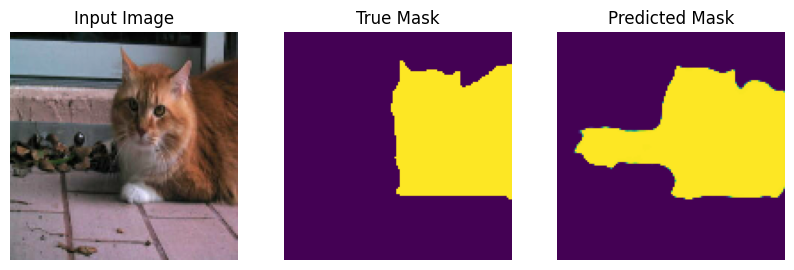

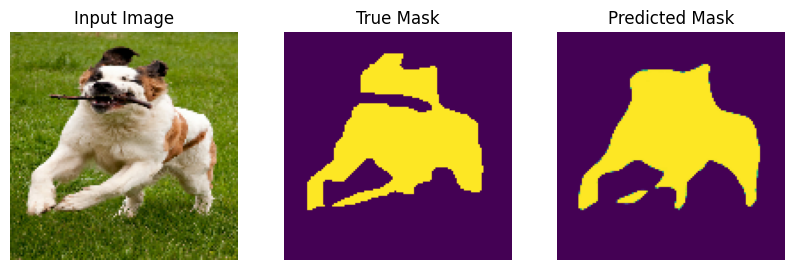

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. CONFIGURATION & HYPERPARAMETERS
# ==========================================
IMG_SIZE = 128
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 15
LEARNING_RATE = 0.001

# ==========================================
# 2. DATASET LOADING & PREPROCESSING
# ==========================================
print("Downloading and loading Oxford-IIIT Pet Dataset...")

# FIX: Removed ':3.*.*' to let TFDS load the latest available version (4.0.0)
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

def preprocess(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Normalize image to [0, 1]
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # PREPARE MASK FOR BINARY CLASSIFICATION (BCE)
    # The dataset has 3 classes: 1 (Pet), 2 (Background), 3 (Border).
    # We convert this to Binary: 1 -> 1.0 (Pet), Others -> 0.0 (Not Pet)
    input_mask = tf.where(input_mask == 1, 1.0, 0.0)

    return input_image, input_mask

# Prepare Train and Test splits
train_dataset = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset prepared.")

# ==========================================
# 3. CUSTOM METRICS & LOSS FUNCTIONS
# ==========================================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# ==========================================
# 4. MODULAR U-NET BUILDER
# ==========================================
def build_unet(downsample_type='mp', upsample_type='tr'):
    """
    downsample_type: 'mp' (MaxPooling) or 'str' (Strided Conv)
    upsample_type: 'tr' (Transpose Conv) or 'ups' (UpSampling2D)
    """
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # --- Encoder Helper ---
    def encoder_block(x, filters, use_strides=False):
        # Two Convs
        x = layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)

        skip = x

        # Downsample
        if use_strides:
            # Strided Convolution
            p = layers.Conv2D(filters, 3, strides=2, padding='same', activation='relu')(x)
        else:
            # Max Pooling
            p = layers.MaxPooling2D()(x)
        return p, skip

    # --- Encoder ---
    use_strides = (downsample_type == 'str')

    p1, s1 = encoder_block(inputs, 32, use_strides)
    p2, s2 = encoder_block(p1, 64, use_strides)
    p3, s3 = encoder_block(p2, 128, use_strides)
    p4, s4 = encoder_block(p3, 256, use_strides)

    # --- Bottleneck ---
    b = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(p4)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(b)
    b = layers.BatchNormalization()(b)

    # --- Decoder Helper ---
    def decoder_block(x, skip, filters):
        # Upsample
        if upsample_type == 'tr':
            x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        else:
            x = layers.UpSampling2D(size=(2, 2))(x)
            x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)

        x = layers.Concatenate()([x, skip])

        # Convs
        x = layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        return x

    # --- Decoder ---
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # --- Output ---
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return models.Model(inputs, outputs)

# ==========================================
# 5. EXPERIMENT RUNNER
# ==========================================
# Define the 4 required experiments
experiments = [
    {"id": "1", "name": "MP + Tr + BCE",        "down": "mp",  "up": "tr",  "loss": "binary_crossentropy"},
    {"id": "2", "name": "MP + Tr + Dice",       "down": "mp",  "up": "tr",  "loss": dice_loss},
    {"id": "3", "name": "StrConv + Tr + BCE",   "down": "str", "up": "tr",  "loss": "binary_crossentropy"},
    {"id": "4", "name": "StrConv + Ups + Dice", "down": "str", "up": "ups", "loss": dice_loss},
]

history_store = {}

for exp in experiments:
    print(f"\n{'='*40}")
    print(f"Running Experiment {exp['id']}: {exp['name']}")
    print(f"{'='*40}")

    # Clean session to free memory
    K.clear_session()

    model = build_unet(downsample_type=exp['down'], upsample_type=exp['up'])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=exp['loss'],
                  metrics=['accuracy', dice_coef])

    history = model.fit(train_batches,
                        epochs=EPOCHS,
                        validation_data=test_batches,
                        verbose=1)

    history_store[exp['name']] = history.history

print("\nAll experiments completed.")

# ==========================================
# 6. RESULTS VISUALIZATION
# ==========================================
plt.figure(figsize=(15, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
for name, hist in history_store.items():
    plt.plot(hist['val_accuracy'], label=name, linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Validation Dice Coefficient
plt.subplot(1, 2, 2)
for name, hist in history_store.items():
    plt.plot(hist['val_dice_coef'], label=name, linewidth=2)
plt.title('Validation Dice Coefficient Comparison')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 7. VISUALIZE PREDICTIONS (Best Model Example)
# ==========================================
# We define a helper to display images
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Show predictions from the last trained model
print("Visualizing predictions from the last trained model...")
for image, mask in test_batches.take(1):
    pred_mask = model.predict(image)

    # Show first 3 images in the batch
    for i in range(3):
        display([image[i], mask[i], pred_mask[i]])

In [2]:
model.save('unet_pet_segmentation.h5')

print("Model saved as unet_pet_segmentation.h5")
print("Go to the 'Output' section of your Kaggle notebook to download this file.")

Model saved as unet_pet_segmentation.h5
Go to the 'Output' section of your Kaggle notebook to download this file.
